# Projet Getaround: Analyse des prix

## Import des modules

In [72]:
import requests
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

import pickle
import joblib

# Some summary libs
from summarytools import dfSummary
from skimpy import skim
import missingno as msno

from config import (
    JEDHA_GETAROUND_PRICING_DATASET_CSV_URL,
    LOCAL_GETAROUND_PRICING_DATASET_CSV_PATH,
    LOCAL_ML_PREPOCESSOR_PKL_PATH,
    LOCAL_ML_LINEAR_REGRESSION_MODEL_PKL_PATH,
    LOCAL_ML_RIDGE_MODEL_PKL_PATH,
    LOCAL_ML_LASSO_MODEL_PKL_PATH,
    LOCAL_ML_RANDOM_FOREST_MODEL_PKL_PATH,
    LOCAL_ML_XGBOOST_MODEL_PKL_PATH,
)

# display settings
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', 1000)          # Expand display width
pd.set_option('display.max_colwidth', None)   # Show full content in each cell

## Chargement des données

In [2]:
# Retrieve locally data analysis dataset
if not LOCAL_GETAROUND_PRICING_DATASET_CSV_PATH.exists():
    response = requests.get(JEDHA_GETAROUND_PRICING_DATASET_CSV_URL)

    with open(LOCAL_GETAROUND_PRICING_DATASET_CSV_PATH, mode="wb") as file:
        file.write(response.content)

In [3]:
pricing_optimization_df = pd.read_csv(LOCAL_GETAROUND_PRICING_DATASET_CSV_PATH)

pricing_optimization_df.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


## Exploration des données

### Analyse descriptive

In [4]:
dfSummary(pricing_optimization_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Unnamed: 0[int64],Mean (sd) : 2421.0 (1398.2)min < med < max:0.0 < 2421.0 < 4842.0IQR (CV) : 2421.0 (1.7),"4,843 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAcZJREFUeJzt10FOwmAQQOH5GyUgpA0hwgG8AUsO4WE9BCdg4cYVOxLSlFAxGqwnACk16kvet22nM4sXElLTNCH9d9lfHyBd4ua7F1JKg4joXfn9LCI+r5ztOk/dTb276/x70zSHUw/PhppSGkwmk8c8z8dttx6Px9u6rh9Go9FLlmUfvzlP3U29+yfmd7tdmVJ6OhXrd7+ovTzPx4vF4lAUxVubxev1erxare7n8/nzbDYr28x2nafupt7ddb6qqv5yuRxvt9teRFwVakREFEXxNp1OX9ssL8tyEBExHA5bz3adp+6m3v0T8xExOPfQP1NCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCsFQhWCoQjBUIRiqEAxVCIYqBEMVgqEKwVCFYKhCMFQhGKoQDFUIhioEQxWCoQrBUIVgqEIwVCEYqhAMVQiGKgRDFYKhCuHmkpeqquq3/fB+v+9HRNR13d9sNne/OU/dTb276/wlfX0BkpY55nO5980AAAAASUVORK5CYII="">",0(0.0%)
2,model_key[object],1. Citroën2. Renault3. BMW4. Peugeot5. Audi6. Nissan7. Mitsubishi8. Mercedes9. Volkswagen10. Toyota11. other,969 (20.0%)916 (18.9%)827 (17.1%)642 (13.3%)526 (10.9%)275 (5.7%)231 (4.8%)97 (2.0%)65 (1.3%)53 (1.1%)242 (5.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAABIhJREFUeJzt3UFqG2cAhuHfRqTxRkIEfIwcQIfoYXsIHSD3MMaziN1s3EVSkyZWJOrROxA9z86xYbR4+YWG+aKr5+fnAYXrpV8Al0NsZMRGRmxkxEZGbGTERkZsZMRG5mqMcTPGeLfQ9b88Pz8/LnRtYqsPHz78uV6vt0tcfJqm+6urq78EdxlW6/V6u9vtHjebzVN54YeHh/f7/X57d3f3bowhtguwGmOMzWbzdHt7+3mB698scE0W4gMCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWY3x9dmy+sJLXJNlraZput/v99uxwLNl0zTdjzG+1NdlGTYIZK78l1lUljrZnGgXaJF1lVXVZcrXVVZVl2updZVV1QVyU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI1MPngxdLlciwxeDF0uk8fCyRi8kClPNqfZhcsGL0YuJIMXIxfGaAcvRi4Xzk1dMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MsngxciFMcLBi5ELHgsnY/BCxgcEMud6G/WWyU/Osq6ypOI1s6+rLKk45FzrKksqfuIDAhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5nZ11WWVBxylnWVJRWv8Vg4GesqMnOdbE4yjppl8GLgwinePHgxcOFUcw1eDFw4yk1dMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mm8evBi4cKpZBi8GLpzCY+FkDF7InHqyObl4s5MGLwYtzOHo4MWghbmcOngxaOHN3NQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyR9dV1lPM5aR1lfUUc7BBIGNdRebYyeZEYza/XFdZVTGng+sqqyrmdmxdZVXFbNzUJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI3Nw8GLowtx+OXgxdGFOHgsnY/BC5seTzUnG2fxn8GLgwjld/zt42e12j9+ie+vXQcKrXgYv3342cOFs3NQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc/QbXmAu3w9eDFw4K4+FkzF4IeMDApnv30a9hXJWL+sqyyrO7Xq9Xm8/fvw4LKs4t+sxxri5ufl76RfC788HBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLXY4zx+Pj4x9IvhN/f9TRN958+fbKs4uw8Fk7GuoqMk42MwQsZgxcyBi9k3NQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjMfCyRi8kPnxi9Je48RjFi+Dl0N/YAjDXFbr9Xq72+0eN5vN04+/fHh4eL/f77d3d3fvxhhi401WY4yx2Wyebm9vPx/4m5vw9fAbc1OXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGqMr48SvfbLQ/8O/8dqmqb7/X6/HQceJTKEYS4eCydj8ELGBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjL/AGiPJE3yAewUAAAAAElFTkSuQmCC"">",0(0.0%)
3,mileage[int64],Mean (sd) : 140962.8 (60196.7)min < med < max:-64.0 < 141080.0 < 1000376.0IQR (CV) : 72282.0 (2.3),"4,786 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjMsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvZiW1igAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAjtJREFUeJzt3UGq2lAYhuH/1KtEpQki6MwNFDpw6CK62DvtrIOswB04ESHEBFNTY0wn7ai01yRa83nfZ37CQV4ihxP4XVVVBnTdh0dvALjGyz0f7pwbmtmgxSNOVVUdb7Uf6LpbqM654XQ6/eL7/qTpM9I0jZ1zr8SKe75RB77vT1ar1TEIgrzu4iRJvDAMJ1EUDcyMUN+5u/71m5kFQZDPZrPvDZcPb7oZyOIwBQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECglvzplqMSbSv1wu/QbrgD/8M9Q2YyKLovDKsvyU5/k3M2s6EA0ws7ffqI3HRG42m8l6vR6dz+dei/0BZnbliMkmYyLjOGY8JG6GwxQkECokECokECokECokECokECokECokECokECokXHWF+ihlWfbNzHfONVl+qqrqeOMt4UE6G2qWZf2iKD4vFot

Le dataset est complet, pas de valeurs manquantes.

`Unnamed: 0` doit être l'ID du véhicule.

Des valeurs un peu étranges pour `mileage`:
- min=-64.0: retour vers le futur ?
- max=1000376.0: sacré endurance ! mais au moins c'est positif.

Un moteur de puissance (`engine_power`) nulle?

In [5]:
# On renomme la colonne ID.
pricing_optimization_df.rename(columns={ "Unnamed: 0": "id" }, inplace=True)

In [6]:
# groupement des features
target_feature = "rental_price_per_day"
numerical_features = ["mileage", "engine_power"]
categorical_features = ["model_key", "fuel", "paint_color", "car_type", "private_parking_available", "has_gps", "has_air_conditioning", "automatic_car", "has_getaround_connect", "has_speed_regulator", "winter_tires"]


In [7]:
fig = px.box(pricing_optimization_df, x="mileage")
fig.show()

In [8]:
pricing_optimization_df[pricing_optimization_df["mileage"] < 0]

,id,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
2938,2938,Renault,-64,230,diesel,black,sedan,True,True,False,True,False,False,True,274


Juste une voiture au kilométrage anormal.

In [9]:
fig = px.box(pricing_optimization_df, x="engine_power")
fig.show()

Une puissance de 0 semble anormale!

### Outliers cleanup

Avant de faire un peu de visualisation, on supprime les outliers.

In [10]:
def drop_iqr_outliers(df, features):
    result_df = df.copy()
    print(f"Cleaning outliers (processing {len(df)} rows)...")
    for feature in features:
        print(f"Cleaning {feature} outliers")
        # let consider original range of values
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # let cleanup the resulting dataset
        result_df = result_df[(result_df[feature] >= lower_bound) & (result_df[feature] <= upper_bound)]
    
    print(f"Cleaning outliers done. Remaining {len(result_df)} rows.")

    return result_df

pricing_optimization_df = drop_iqr_outliers(pricing_optimization_df, numerical_features)

pricing_optimization_df

Cleaning outliers (processing 4843 rows)...
Cleaning mileage outliers
Cleaning engine_power outliers
Cleaning outliers done. Remaining 4162 rows.


,id,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183
6,6,Citroën,205219,145,diesel,grey,convertible,True,True,False,False,True,True,True,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,4838,Toyota,39743,110,diesel,black,van,False,True,False,False,False,False,True,121
4839,4839,Toyota,49832,100,diesel,grey,van,False,True,False,False,False,False,True,132
4840,4840,Toyota,19633,110,diesel,grey,van,False,True,False,False,False,False,True,130
4841,4841,Toyota,27920,110,diesel,brown,van,True,True,False,False,False,False,True,151


### Analyse (bi/tri)variée

#### Features numériques

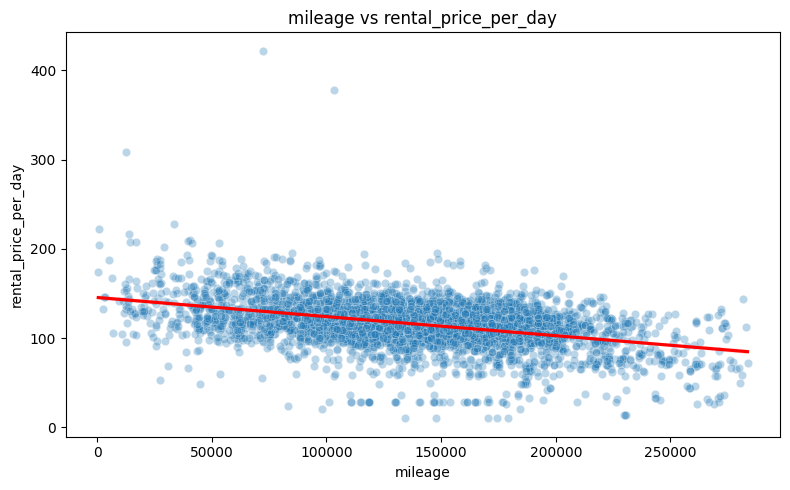

Corrélation entre mileage et rental_price_per_day : -0.41


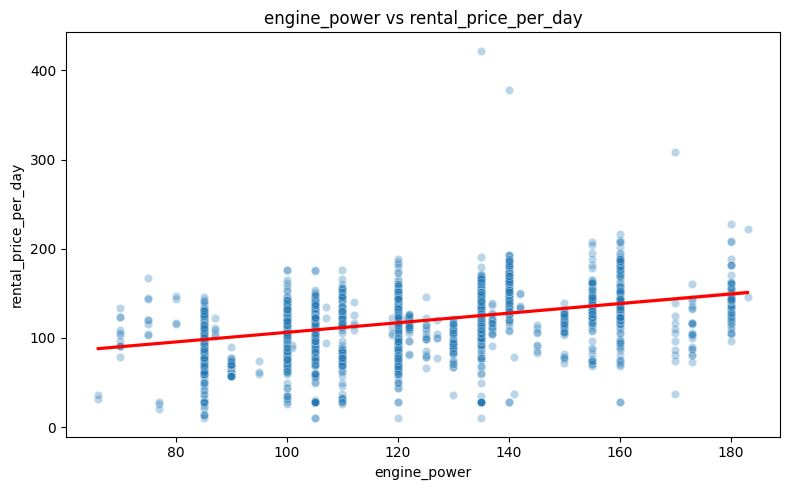

Corrélation entre engine_power et rental_price_per_day : 0.45


In [11]:
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=pricing_optimization_df, x=feature, y=target_feature, alpha=0.3)
    sns.regplot(data=pricing_optimization_df, x=feature, y=target_feature, scatter=False, color='red')
    plt.title(f"{feature} vs {target_feature}")
    plt.xlabel(feature)
    plt.ylabel(target_feature)
    plt.tight_layout()
    plt.show()
    
    # Corrélation
    corr = pricing_optimization_df[[feature, target_feature]].corr().iloc[0, 1]
    print(f"Corrélation entre {feature} et {target_feature} : {corr:.2f}")

On décèle quelques tendances:
- plus le kilométrage est élevé moins le prix de location sera élevé
- plus la puissance est élevée plus le prix de location sera élevé

On peut penser que les voitures puissantes sont louées plus cher sauf quand elles ont trop de kilomètres.

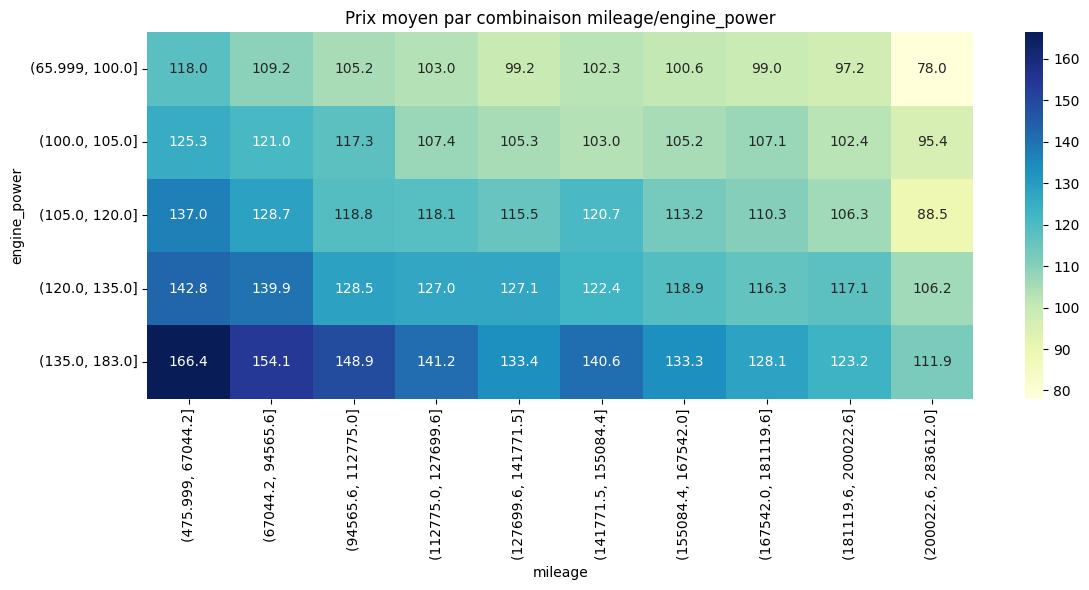

In [13]:
# On crée des "bins" (tranches)
pricing_optimization_df["mileage_bin"] = pd.qcut(pricing_optimization_df["mileage"], q=10)
pricing_optimization_df["power_bin"] = pd.qcut(pricing_optimization_df["engine_power"], q=5)

# Moyenne de la target dans chaque bin combiné
pivot_table = pricing_optimization_df.pivot_table(
    index="power_bin", 
    columns="mileage_bin", 
    values=target_feature, 
    aggfunc="mean",
    observed=True
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Prix moyen par combinaison mileage/engine_power")
plt.xlabel("mileage")
plt.ylabel("engine_power")
plt.tight_layout()
plt.show()

Effectivement, moins de kilomètres et plus de puissance = cher.

#### Features catégorielles

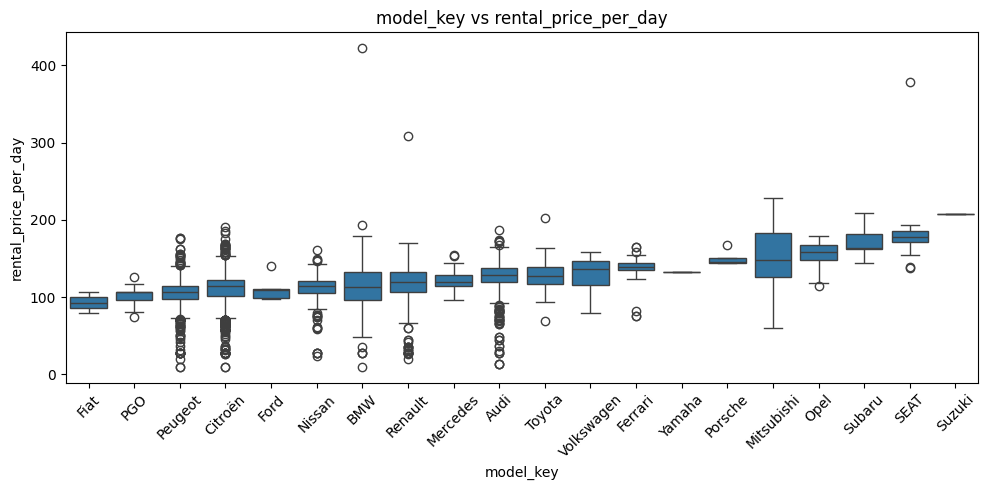

Moyenne de rental_price_per_day selon model_key :
model_key
Fiat           93.000000
PGO           101.000000
Peugeot       104.546341
Citroën       109.895811
Ford          111.000000
Nissan        111.161765
BMW           114.984293
Renault       118.234393
Mercedes      121.360825
Audi          123.133136
Toyota        127.675000
Volkswagen    129.897959
Ferrari       132.352941
Yamaha        133.000000
Porsche       150.500000
Mitsubishi    151.965909
Opel          155.575758
Subaru        169.769231
SEAT          181.117647
Suzuki        207.000000
Name: rental_price_per_day, dtype: float64



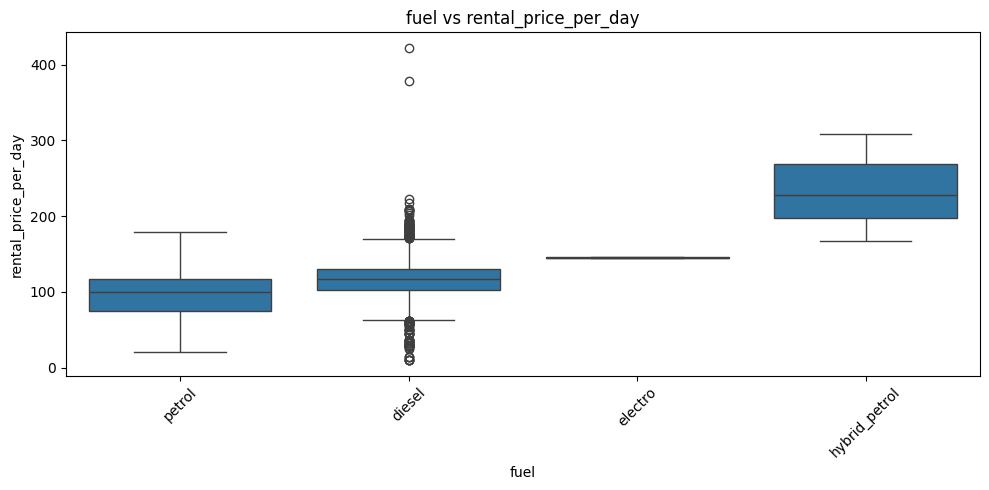

Moyenne de rental_price_per_day selon fuel :
fuel
petrol            96.366906
diesel           116.285039
electro          145.000000
hybrid_petrol    234.666667
Name: rental_price_per_day, dtype: float64



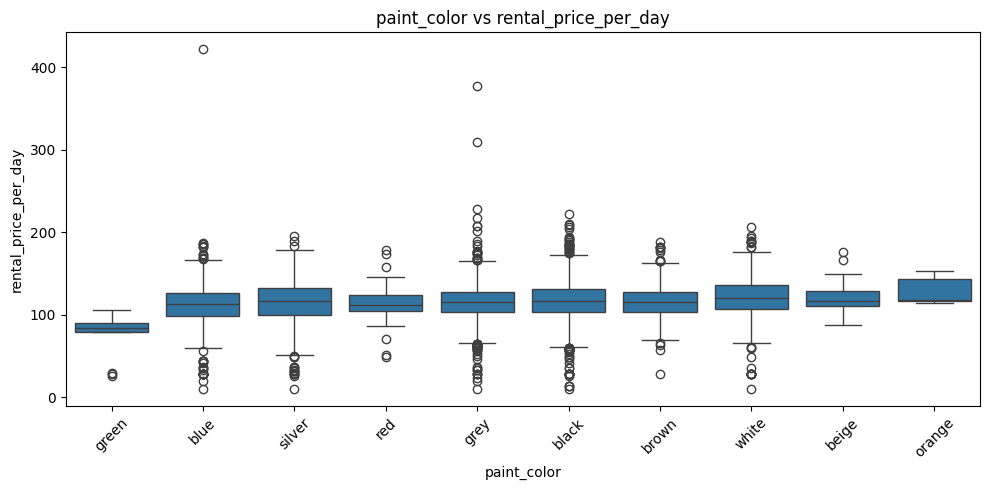

Moyenne de rental_price_per_day selon paint_color :
paint_color
green      75.285714
blue      112.204659
silver    112.645390
red       114.617021
grey      115.458333
black     116.371119
brown     117.512658
white     120.375536
beige     120.473684
orange    129.200000
Name: rental_price_per_day, dtype: float64



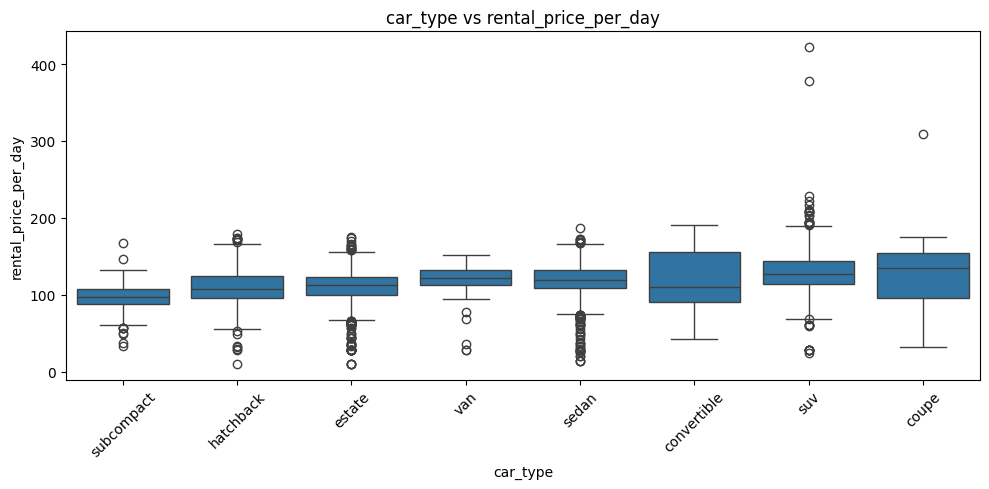

Moyenne de rental_price_per_day selon car_type :
car_type
subcompact      95.669565
hatchback      109.687879
estate         109.929568
van            115.837209
sedan          117.813253
convertible    120.325000
suv            129.747198
coupe          130.887324
Name: rental_price_per_day, dtype: float64



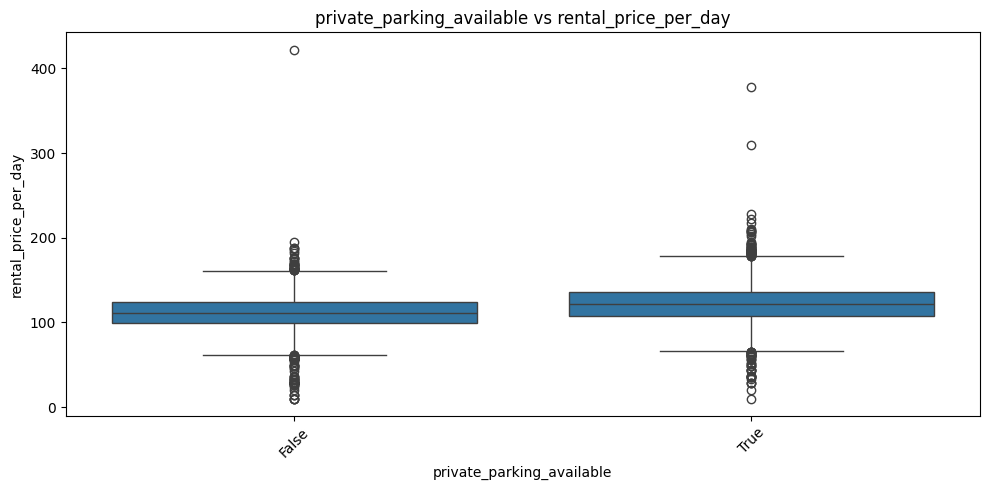

Moyenne de rental_price_per_day selon private_parking_available :
private_parking_available
False    109.900435
True     121.484472
Name: rental_price_per_day, dtype: float64



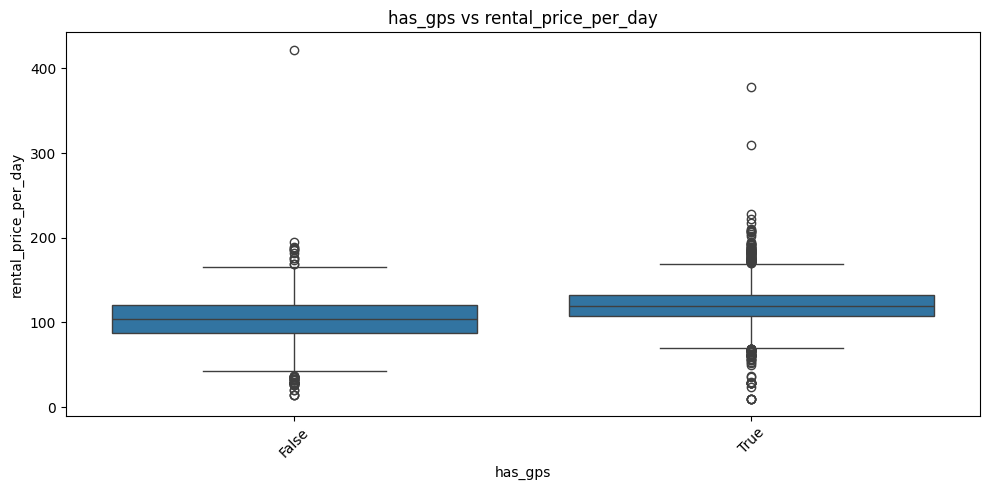

Moyenne de rental_price_per_day selon has_gps :
has_gps
False    101.707527
True     119.759592
Name: rental_price_per_day, dtype: float64



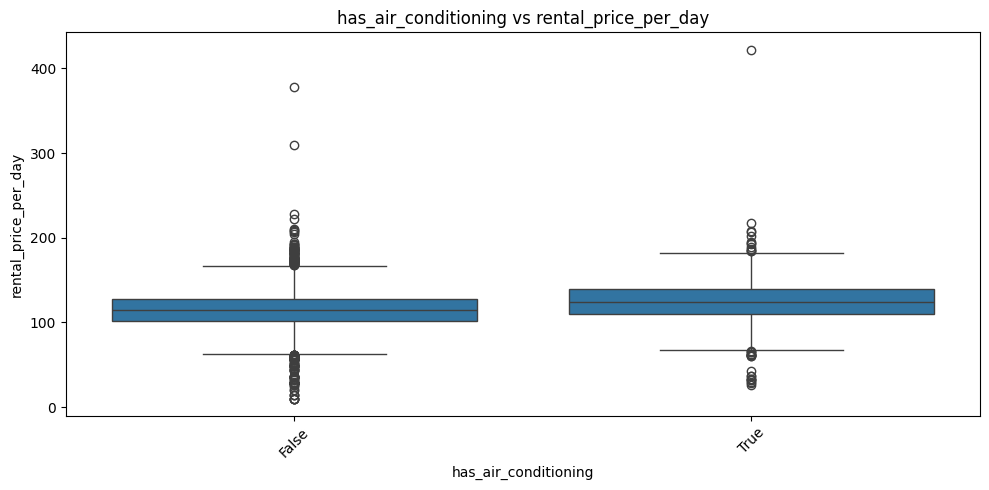

Moyenne de rental_price_per_day selon has_air_conditioning :
has_air_conditioning
False    114.284979
True     123.275862
Name: rental_price_per_day, dtype: float64



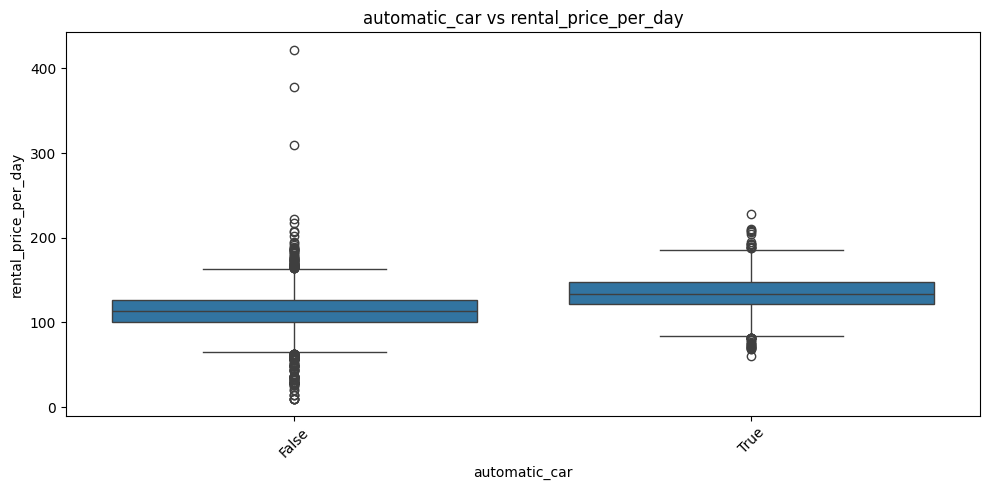

Moyenne de rental_price_per_day selon automatic_car :
automatic_car
False    112.424430
True     134.986864
Name: rental_price_per_day, dtype: float64



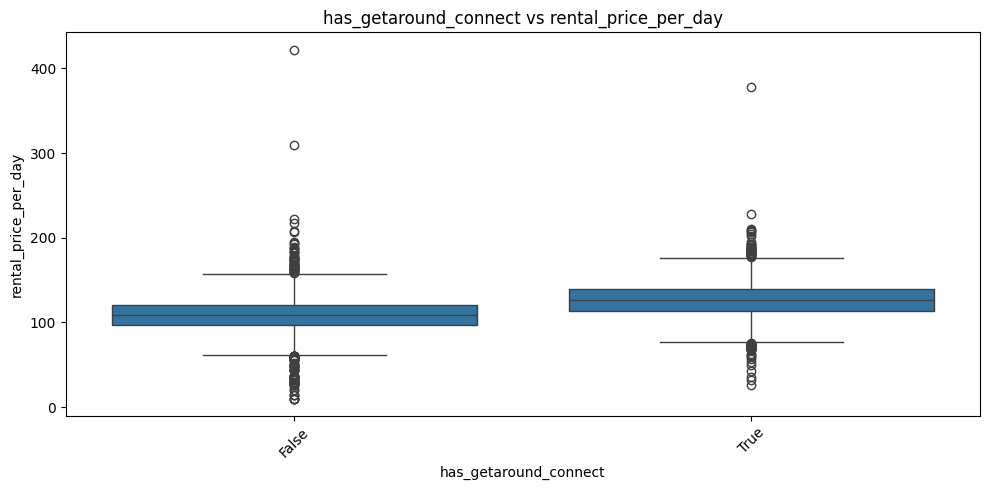

Moyenne de rental_price_per_day selon has_getaround_connect :
has_getaround_connect
False    107.542330
True     126.720158
Name: rental_price_per_day, dtype: float64



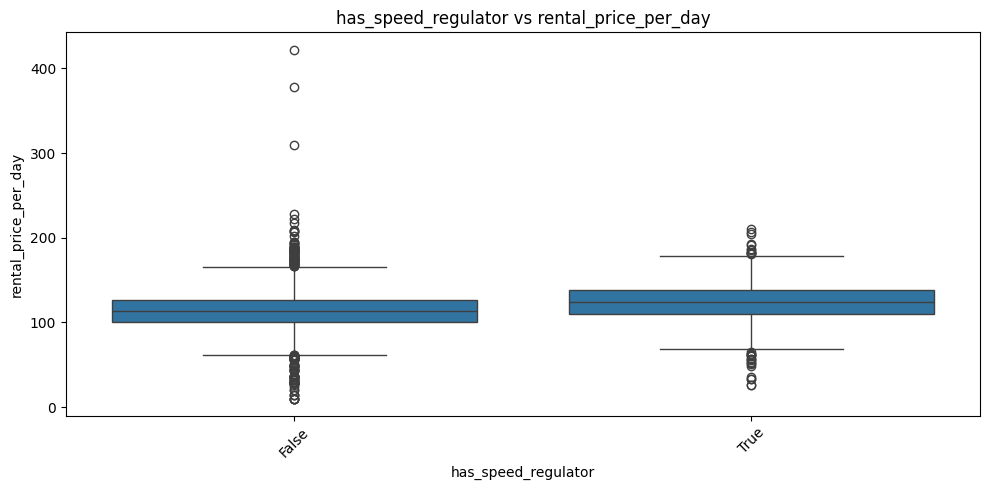

Moyenne de rental_price_per_day selon has_speed_regulator :
has_speed_regulator
False    113.539353
True     123.833710
Name: rental_price_per_day, dtype: float64



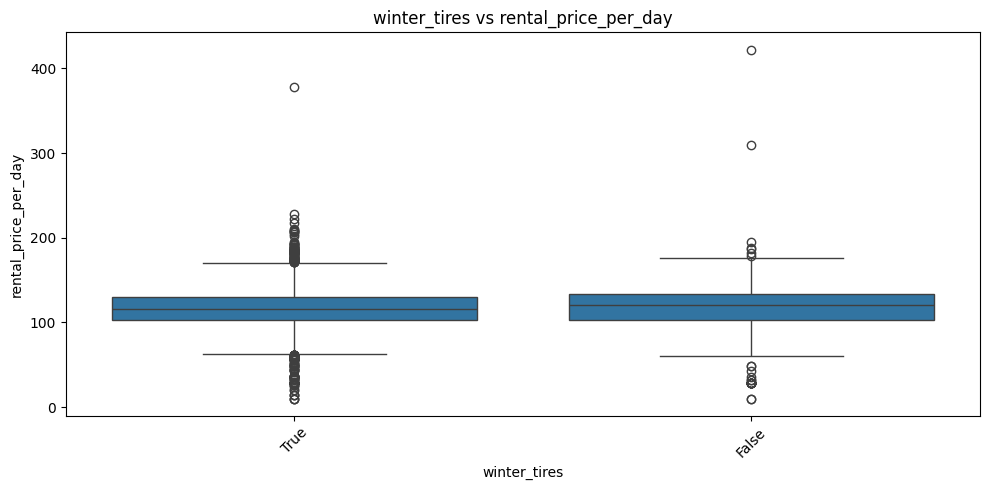

Moyenne de rental_price_per_day selon winter_tires :
winter_tires
True     115.709176
False    115.937500
Name: rental_price_per_day, dtype: float64



In [14]:
# 🔍 Analyse des variables catégorielles
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    order = pricing_optimization_df.groupby(feature)[target_feature].mean().sort_values().index
    sns.boxplot(data=pricing_optimization_df, x=feature, y=target_feature, order=order)
    plt.xticks(rotation=45)
    plt.title(f"{feature} vs {target_feature}")
    plt.xlabel(feature)
    plt.ylabel(target_feature)
    plt.tight_layout()
    plt.show()
    
    # Moyennes par catégorie
    means = pricing_optimization_df.groupby(feature)[target_feature].mean().sort_values()
    print(f"Moyenne de {target_feature} selon {feature} :\n{means}\n")

Les hybrides se louent en moyenne plus cher.

## Machine Learning

Evaluation de quelques modèles, du plus simple au plus élaborés, permettant d'estimer le coût de location pour un descriptif de véhicule (ajout d'un véhicule à la flotte louée).

- Modèles de base
    - Régression Linéaire (Linear Regression)
    - Ridge / Lasso / ElasticNet
- Modèles non linéaires plus puissants
    - Random Forest Regressor
- Gradient Boosting Machines (GBM)
    - XGBoost / LightGBM / CatBoost

### Préprocesseur

In [15]:
# Numerical features
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

# Categorical features
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first")),
    ]
)

# Build features prepocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### Préparation train/test datasets

In [40]:
ml_df = pricing_optimization_df[numerical_features + categorical_features + [target_feature]]

X_df = ml_df.drop(columns=target_feature)
y_df = ml_df[target_feature]

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Preprocess the train & test datasets
X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

y_train = y_train_df.tolist()
y_test = y_test_df.tolist()


In [41]:
# It worth saving the preprocessor for future inference API
with open(LOCAL_ML_PREPOCESSOR_PKL_PATH, 'wb') as file:
    pickle.dump(preprocessor, file)

### Modèles

#### Evaluation

In [67]:
# A place to collect all models metrics
models_metrics = []

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None):
    """
    Évalue un modèle de régression sur jeu d'entraînement et de test.

    Args:
        model: objet avec .predict()
        X_train, y_train: données d'entraînement
        X_test, y_test: données de test
        model_name (str): nom du modèle à afficher (optionnel)

    Retourne:
        dict avec MAE, RMSE et R² sur train et test
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    metrics = {
        "model": model_name or type(model).__name__,
        "MAE_train": mean_absolute_error(y_train, y_train_pred),
        "RMSE_train": mean_squared_error(y_train, y_train_pred),
        "R2_train": r2_score(y_train, y_train_pred),
        "MAE_test": mean_absolute_error(y_test, y_test_pred),
        "RMSE_test": mean_squared_error(y_test, y_test_pred),
        "R2_test": r2_score(y_test, y_test_pred)
    }
    
    # scores = cross_val_score(linear_regression,X_train, Y_train, cv=5)
    # avg = scores.mean()
    # std = scores.std()
    # print('Cross-validated accuracy : {}\nstandard deviation : {}'.format(avg, std))
    # print("R2 score on test set is finally: ", linear_regression.score(X_test, Y_test) + std, "or ", linear_regression.score(X_test, Y_test) - std)
    # print("and that's under the R2 score on training set :", linear_regression.score(X_train, Y_train))

    # Affichage des métriques
    print(f"\n📊 Évaluation pour {metrics['model']}")
    for key, value in metrics.items():
        if key != "model":
            print(f"{key}: {value:.3f}")
    
    return metrics

#### Modèle linaire

In [68]:
linear_regression_model = LinearRegression()

print("Training model...")
linear_regression_model.fit(X_train, y_train)
print("...Done")

# Save the model
joblib.dump(linear_regression_model, LOCAL_ML_LINEAR_REGRESSION_MODEL_PKL_PATH)

# Evaluate the model and store metrics
m = evaluate_model(linear_regression_model, X_train, y_train, X_test, y_test, model_name="Régression Linéraire")
models_metrics.append(m)


Training model...
...Done

📊 Évaluation pour Régression Linéraire
MAE_train: 11.142
RMSE_train: 288.787
R2_train: 0.599
MAE_test: 11.663
RMSE_test: 287.641
R2_test: 0.621


#### Modèle Ridge

In [69]:
ridge_model = Ridge()

ridge_model_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

print("Training model...")
ridge_gridsearch = GridSearchCV(ridge_model, param_grid=ridge_model_params, cv=5, scoring='r2', n_jobs=-1)
ridge_gridsearch.fit(X_train, y_train)
print("...Done")

best_ridge_model_params = ridge_gridsearch.best_params_

print()
print("Best hyperparameters : ", best_ridge_model_params)
print("Best score : ", ridge_gridsearch.best_score_)
print()

# Save the model
joblib.dump(ridge_gridsearch.best_estimator_, LOCAL_ML_RIDGE_MODEL_PKL_PATH)

# Evaluate the model and store metrics
m = evaluate_model(ridge_gridsearch.best_estimator_, X_train, y_train, X_test, y_test, model_name="Ridge")
models_metrics.append(m)

Training model...
...Done

Best hyperparameters :  {'alpha': 1}
Best score :  0.5867911531105635


📊 Évaluation pour Ridge
MAE_train: 11.152
RMSE_train: 290.117
R2_train: 0.597
MAE_test: 11.612
RMSE_test: 286.269
R2_test: 0.623


#### Modèle Lasso

In [70]:
lasso_model = Lasso(max_iter=10000)

lasso_model_params = {
  "alpha" : [0.001, 0.01, 0.1, 1, 2, 5, 100, 200, 500, 1000, 2000, 5000, 10000]
}

print("Training model...")
lasso_gridsearch = GridSearchCV(lasso_model, param_grid=lasso_model_params, cv=5, scoring='r2', n_jobs=-1)
lasso_gridsearch.fit(X_train, y_train)
print("...Done")

best_lasso_model_params = lasso_gridsearch.best_params_

print()
print("Best hyperparameters : ", best_lasso_model_params)
print("Best score : ", lasso_gridsearch.best_score_)
print()

# Save the model
joblib.dump(lasso_gridsearch.best_estimator_, LOCAL_ML_LASSO_MODEL_PKL_PATH)

# Evaluate the model and store metrics
m = evaluate_model(lasso_gridsearch.best_estimator_, X_train, y_train, X_test, y_test, model_name="Lasso")
models_metrics.append(m)

Training model...
...Done

Best hyperparameters :  {'alpha': 0.01}
Best score :  0.5844874067118588


📊 Évaluation pour Lasso
MAE_train: 11.162
RMSE_train: 290.821
R2_train: 0.596
MAE_test: 11.590
RMSE_test: 285.983
R2_test: 0.623


#### Modèle RandomForest

In [75]:
random_forest_model = RandomForestRegressor(oob_score=True)
random_forest_model_params = {
    'max_depth' : [5, 7, 10],
    'min_samples_split' : [3, 5, 7, 10],
    'min_samples_leaf': [2, 5, 10],
    'n_estimators': [50, 80, 100, 150],
}

print("Training model...")

random_forest_gridsearch = GridSearchCV(estimator=random_forest_model, param_grid=random_forest_model_params, cv=5, scoring='r2', n_jobs=-1)
random_forest_gridsearch.fit(X_train, y_train)

print("...Done.")

best_random_forest_model_params = random_forest_gridsearch.best_params_

print()
print("Best hyperparameters : ", best_random_forest_model_params)
print("Best score : ", random_forest_gridsearch.best_score_)
print()

# Save the model
joblib.dump(random_forest_gridsearch.best_estimator_, LOCAL_ML_RANDOM_FOREST_MODEL_PKL_PATH)

# Evaluate the model and store metrics
m = evaluate_model(random_forest_gridsearch.best_estimator_, X_train, y_train, X_test, y_test, model_name="Random Forest")
models_metrics.append(m)                                             

Training model...


...Done.

Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 80}
Best score :  0.6030508600129876


📊 Évaluation pour Random Forest
MAE_train: 7.942
RMSE_train: 148.560
R2_train: 0.794
MAE_test: 10.623
RMSE_test: 252.509
R2_test: 0.667


#### Modèle XGBoost

In [77]:
xgboost_model = XGBRegressor()

xgboost_model_params = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
    'max_depth': [3, 5, 7, 10],
    
    'colsample_bytree': [0.5, 0.75, 1],
    'gamma': [0, 0.1, 0.3, 0.5, 1.0],
    'min_child_weight': [1, 3, 5],
}

print("Training model...")

xgboost_gridsearch = GridSearchCV(estimator=xgboost_model, param_grid=xgboost_model_params, cv=5, scoring='r2', n_jobs=-1)
xgboost_gridsearch.fit(X_train, y_train)

print("...Done.")

best_xgboost_model_params = xgboost_gridsearch.best_params_

print()
print("Best hyperparameters : ", best_xgboost_model_params)
print("Best score : ", xgboost_gridsearch.best_score_)
print()

# Save the model
joblib.dump(xgboost_gridsearch.best_estimator_, LOCAL_ML_XGBOOST_MODEL_PKL_PATH)

# Evaluate the model and store metrics
m = evaluate_model(xgboost_gridsearch.best_estimator_, X_train, y_train, X_test, y_test, model_name="XGBoost")
models_metrics.append(m)    


Training model...


/home/vscode/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


80 fits failed out of a total of 13500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.venv/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/home/vscode/.venv/lib/python3.11/site-packages/xgboost/sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
 

XGBoostError: [11:58:50] /workspace/src/data/array_interface.cu:44: Check failed: err == cudaGetLastError() (0 vs. 2) : 
Stack trace:
  [bt] (0) /home/vscode/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x2a6ebc) [0x7f99f46a6ebc]
  [bt] (1) /home/vscode/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0xb862bc) [0x7f99f4f862bc]
  [bt] (2) /home/vscode/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x565eae) [0x7f99f4965eae]
  [bt] (3) /home/vscode/.venv/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0x10b) [0x7f99f45b3e4b]
  [bt] (4) /usr/lib/x86_64-linux-gnu/libffi.so.8(+0x6f7a) [0x7f9abfe3bf7a]
  [bt] (5) /usr/lib/x86_64-linux-gnu/libffi.so.8(+0x640e) [0x7f9abfe3b40e]
  [bt] (6) /usr/lib/x86_64-linux-gnu/libffi.so.8(ffi_call+0xcd) [0x7f9abfe3bb0d]
  [bt] (7) /usr/local/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x10c5f) [0x7f9abfe5ac5f]
  [bt] (8) /usr/local/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x7cd6) [0x7f9abfe51cd6]



#### Résultats

In [51]:
df_results = pd.DataFrame(models_metrics)
display(df_results.sort_values("R2_test", ascending=False))

,model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,Régression Linéraire,11.142245,288.786742,0.599081,11.662974,287.641275,0.620854
